# Mobile Fraud Detection

### Objective  
**To improve and come up with better threshold to capture the fraud transaction.**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import original data set
original = pd.read_csv('original data.csv')
original.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# information of original data
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Header Explaination

There are totally 11 columns and 6362620 entries.  
**step** - Maps a unit of time in the real world. 1 step is one hour of time.  
**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.  
**amount** - Amount of the transaction in local currency.  
**nameOrig** - Customer who started the transaction.  
**oldbalanceOrg** - Initial balance before the transaction.  
**newbalanceOrig** - New balance after the transaction.   
**nameDest** - Customer who is the recipient of transaction.   
**oldbalanceDest** - Initial balance recipient before transaction.    
**newbalanceDest** - New balance recipient after the transaction.   
**isFraud** - This is the transactions made by the fraudulent agents inside the simulation.    
**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal. It is the indicator which the simulation is used to flag the transaction using some threshold.

#### Checking missing value

In [4]:
def now():
    tmp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return tmp

def checking_na(df):
    try:
        if (isinstance(df, pd.DataFrame)):
            df_na_bool = pd.concat([df.isnull().any(), df.isnull().sum(), (df.isnull().sum()/df.shape[0])*100], axis=1, keys=['df_bool', 'df_amt', 'missing_ratio_percent'])
            df_na_bool = df_na_bool.loc[df_na_bool['df_bool'] == True]
            return df_na_bool
        else:
            print("{}: The input is not pandas DataFrame".format(now()))
            
    except(UnboundLocalError, RuntimeError):
        print("{}: Something is wrong".format(now()))

In [5]:
print(checking_na(original))

Empty DataFrame
Columns: [df_bool, df_amt, missing_ratio_percent]
Index: []


## Exploratory Data Analysis

In this section, EDA is performed to find the characteristics of the original dataset. There are three main findings:  
* The fraud transaction only occurs when the transaction type is "CASH_OUT" or "TRANSFER"
* Only 16 instances have "isFlaggedFraud" labeled with "1"
* Majority of names under "nameOrig" and "nameDest" are different

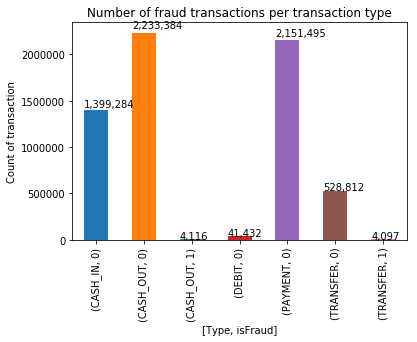

In [6]:
# plot the number of transactions for each combination of "type" and "isFraud"
ax = original.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("Number of fraud transactions per transaction type")
ax.set_xlabel("[Type, isFraud]")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.02))

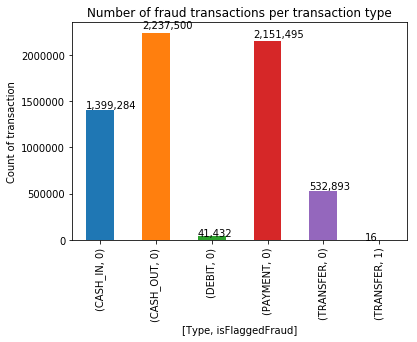

In [7]:
# plot the number of transactions for each combination of "type" and "isFlaggedFraud"
ax = original.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("Number of fraud transactions per transaction type")
ax.set_xlabel("[Type, isFlaggedFraud]")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.02))

In [8]:
# Check the number of "isFraud" and "isFlaggedFraud" cases
print("Total number of isFraud cases:", original.isFraud.sum())
print("Total number of isFlaggedFraud cases:", original.isFlaggedFraud.sum())
print("Number of common cases:", len(original[(original.isFraud == 1) & (original.isFlaggedFraud == 1)]))

Total number of isFraud cases: 8213
Total number of isFlaggedFraud cases: 16
Number of common cases: 16


In [9]:
# Check the uniqueness of origin and destination names
orig = original['nameOrig'].value_counts()
dest = original['nameDest'].value_counts()
print("Porpotion of unique nameOrig:", (len(original) - len(orig[orig>1]))/len(original))
print("Porpotion of unique nameDest:", (len(original)-len(dest[dest>1]))/len(original))

Porpotion of unique nameOrig: 0.9985386523161842
Porpotion of unique nameDest: 0.9277564902508715


## Feature Selection

### Random Forest

In [11]:
# apply one-hot representation on attribute "type"
original['PAYMENT'] = original.type.apply(lambda x: 1 if x=='PAYMENT' else 0)
original['TRANSFER'] = original.type.apply(lambda x: 1 if x=='TRANSFER' else 0)
original['CASH_OUT'] = original.type.apply(lambda x: 1 if x=='CASH_OUT' else 0)
original['CASH_IN'] = original.type.apply(lambda x: 1 if x=='CASH_IN' else 0)
original['DEBIT'] = original.type.apply(lambda x: 1 if x=='DEBIT' else 0)

In [24]:
# drop unnecessary attributes
original_new = original.drop(['type', 'nameDest', 'nameOrig','isFlaggedFraud'], axis=1)

In [25]:
# Extract factor and target variables
factor = original_new.drop('isFraud', axis=1)
X = np.array(factor)
Y = np.array(original_new['isFraud'])
names = np.array(factor.columns)

In [28]:
# Perform Random Forest to get coefficiencies
rf = RandomForestRegressor(n_estimators=5)
rf.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [29]:
Features = pd.DataFrame(sorted(zip(names, map(lambda x: round(x, 4), rf.feature_importances_)),reverse=True))
Features

,0,1
0,step,0.0655
1,oldbalanceOrg,0.3478
2,oldbalanceDest,0.0894
3,newbalanceOrig,0.0642
4,newbalanceDest,0.2684
5,amount,0.1504
6,TRANSFER,0.0045
7,PAYMENT,0.0000
8,DEBIT,0.0000
9,CASH_OUT,0.0045


In [30]:
rf2 = RandomForestRegressor(n_estimators=3)
rf2.fit(X,Y)
Features = pd.DataFrame(sorted(zip(names, map(lambda x: round(x, 4), rf2.feature_importances_)),reverse=True))
Features

,0,1
0,step,0.0667
1,oldbalanceOrg,0.3450
2,oldbalanceDest,0.0995
3,newbalanceOrig,0.0352
4,newbalanceDest,0.2881
5,amount,0.1575
6,TRANSFER,0.0019
7,PAYMENT,0.0000
8,DEBIT,0.0000
9,CASH_OUT,0.0017


### Pearson Correlation

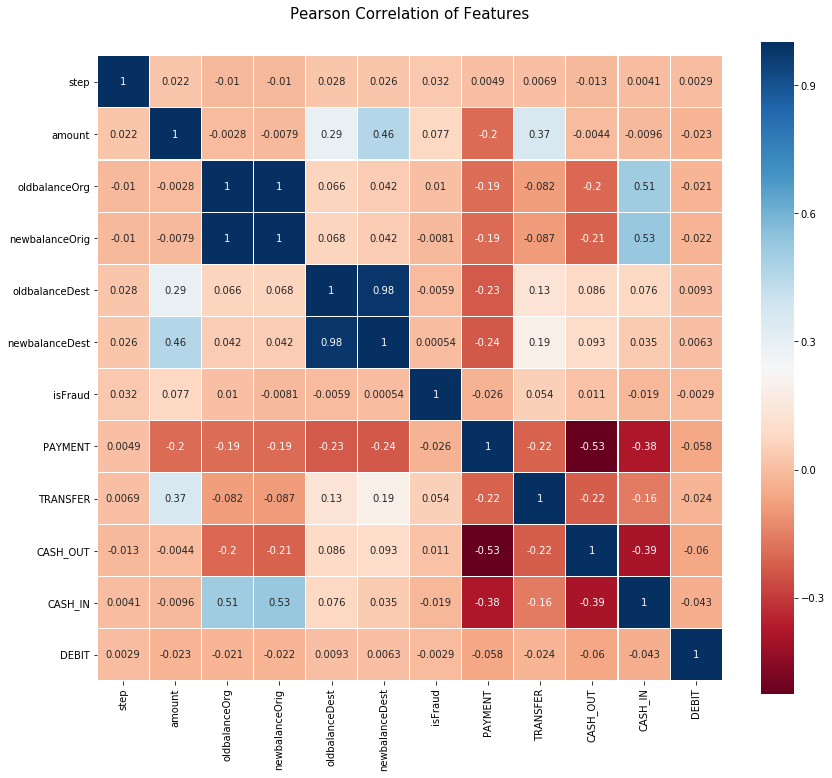

In [26]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(original_new.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)